In [ ]:
!pip install tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.8 MB/s eta 0:00:00
     ━━━

# **Dataset**

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/CICIoV2024/binary.csv')
data


,ID0,ID1,ID2,ID3,ID4,ID5,ID6,ID7,ID8,ID9,...,DATA_710,DATA_711,DATA_712,DATA_713,DATA_714,DATA_715,DATA_716,label,category,specific_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
2,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,BENIGN,BENIGN,BENIGN
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
4,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,BENIGN,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408214,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL
1408215,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL
1408216,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL
1408217,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,ATTACK,SPOOFING,STEERING_WHEEL


# **Binary Classification using "label"**

**2 clients, 1D conv, Adam, lr=0.001**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CICIoV2024/binary.csv")

In [ ]:
# Encode string labels into numerical values
label_mapping = {label: index for index, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create train data for clients with a smaller batch size
def create_tf_dataset_for_client(client_data, batch_size=16):
    data = client_data.iloc[:, :-3].values.astype(np.float32)  # Exclude the last three columns (label, category, specific_class)
    labels = client_data['label'].values.astype(np.int32)
    return tf.data.Dataset.from_tensor_slices((data, labels)).batch(batch_size)

# Use only a subset of the training data for each client
client_data_splits = [client_data.sample(frac=0.2, random_state=42) for client_data in np.array_split(train_df, 2)]

# Create TF datasets for each client with reduced batch size
train_data = [create_tf_dataset_for_client(client_data, batch_size=16) for client_data in client_data_splits]

# Use only a subset of the test data
test_df_subset = test_df.sample(frac=0.5, random_state=42)
test_data = tf.data.Dataset.from_tensor_slices(
    (test_df_subset.iloc[:, :-3].values.astype(np.float32), test_df_subset['label'].values.astype(np.int32))
).batch(16)


In [ ]:
df_shape = df.shape[1]

In [ ]:
del df

In [ ]:
# Define the Keras model
def build_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((df_shape - 3, 1), input_shape=(df_shape - 3,)),  # Adjust input shape based on new data
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, 2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(label_mapping), activation='softmax')
    ])
    return model

# Wrap a Keras model for use with TFF.
def model_fn():
    keras_model = build_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
)

state = trainer.initialize()

# Lists to store training and testing metrics
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []
precisions = []
recalls = []
f1_scores = []
mean_squared_errors = []

print("Training and Testing Results")

for round_num in range(3):
    # Training
    state, metrics = trainer.next(state, train_data)

    train_accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    train_loss = metrics['client_work']['train']['loss']
    num_examples = metrics['client_work']['train']['num_examples']
    num_batches = metrics['client_work']['train']['num_batches']
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Round {round_num+1}, Training accuracy: {train_accuracy:.4f}, Training loss: {train_loss:.4f}, Num examples: {num_examples}, Num batches: {num_batches}')

    # Testing
    eval_process = tff.learning.build_federated_evaluation(model_fn)
    model_weights = trainer.get_model_weights(state)
    test_metrics = eval_process(model_weights, [test_data])['eval']
    test_accuracy = test_metrics['sparse_categorical_accuracy']
    test_loss = test_metrics['loss']
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)
    print(f"Round {round_num+1}, Testing accuracy: {test_accuracy:.4f}, Testing loss: {test_loss:.4f}, Num examples: {test_metrics['num_examples']}, Num batches: {test_metrics['num_batches']}")

    # Evaluate precision, recall, and F1 score for the current round
    keras_model = build_keras_model()
    keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    keras_model.set_weights(model_weights.trainable)

    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = np.argmax(keras_model.predict(test_data), axis=1)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    print(f'Round {round_num+1}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Training and Testing Results
Round 1, Training accuracy: 0.9994, Training loss: 0.0018, Num examples: 225315, Num batches: 14084


<ipython-input-10-f9673d87bd7e>:58: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 1, Testing accuracy: 1.0000, Testing loss: 0.0001, Num examples: 140822, Num batches: 8802
8802/8802 [==============================] - 21s 2ms/step
Round 1, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Round 2, Training accuracy: 0.9999, Training loss: 0.0007, Num examples: 225315, Num batches: 14084


<ipython-input-10-f9673d87bd7e>:58: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 2, Testing accuracy: 1.0000, Testing loss: 0.0000, Num examples: 140822, Num batches: 8802
8802/8802 [==============================] - 21s 2ms/step
Round 2, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Round 3, Training accuracy: 0.9999, Training loss: 0.0004, Num examples: 225315, Num batches: 14084


<ipython-input-10-f9673d87bd7e>:58: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(model_fn)


Round 3, Testing accuracy: 1.0000, Testing loss: 0.0001, Num examples: 140822, Num batches: 8802
8802/8802 [==============================] - 22s 2ms/step
Round 3, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


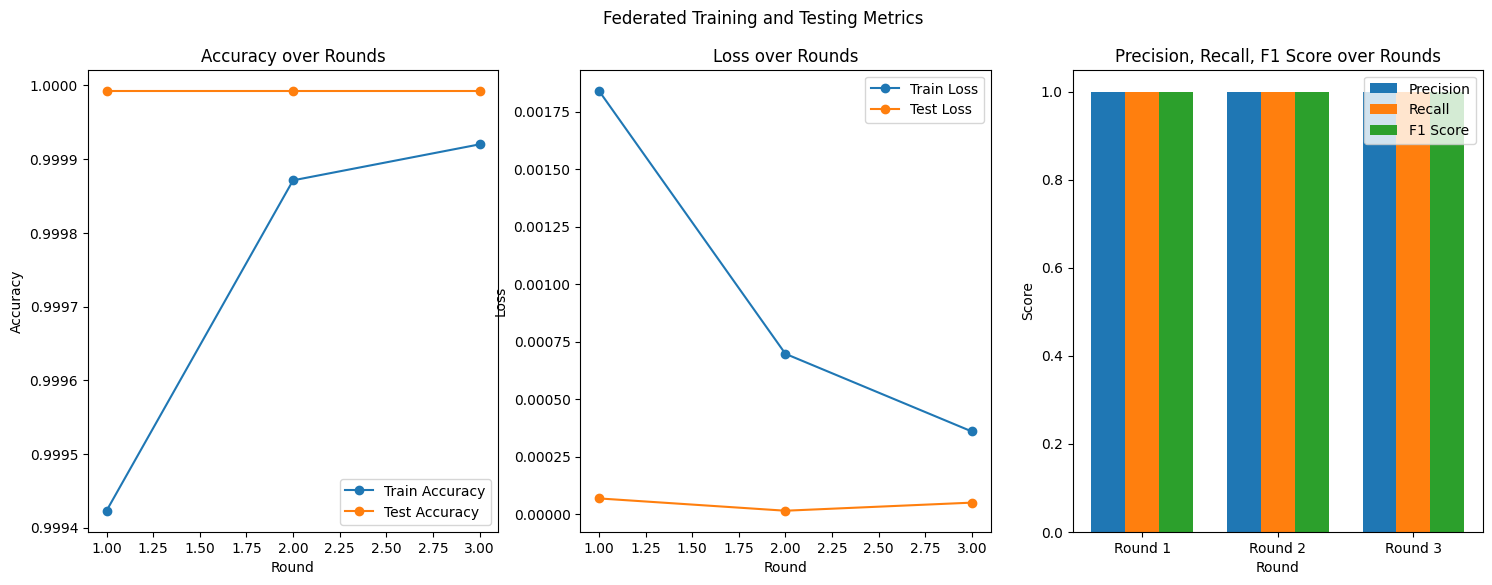

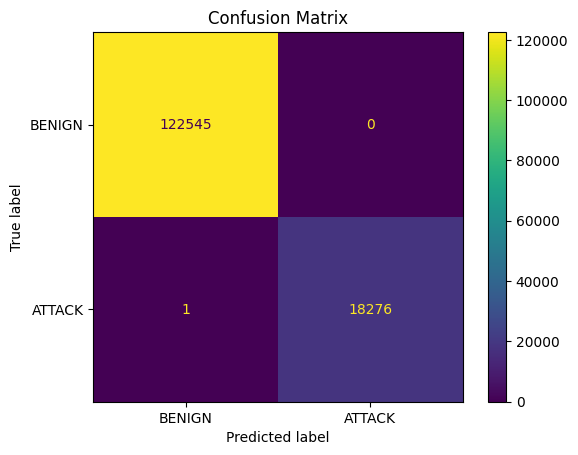

In [ ]:
# Plot accuracy and loss over rounds
rounds = range(1, 4)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(rounds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(rounds, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rounds, train_losses, marker='o', label='Train Loss')
plt.plot(rounds, test_losses, marker='o', label='Test Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
bar_width = 0.25
bar_positions = np.arange(len(rounds))

plt.bar(bar_positions - bar_width, precisions, width=bar_width, label='Precision')
plt.bar(bar_positions, recalls, width=bar_width, label='Recall')
plt.bar(bar_positions + bar_width, f1_scores, width=bar_width, label='F1 Score')
plt.title('Precision, Recall, F1 Score over Rounds')
plt.xlabel('Round')
plt.ylabel('Score')
plt.xticks(bar_positions, [f'Round {i}' for i in rounds])
plt.legend()

plt.suptitle('Federated Training and Testing Metrics')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()